In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "french_to_english_product.csv"

# Load the latest version
fr_en_kaggle_dataset = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dargolex/french-reviews-on-amazon-items-and-en-translation",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

from pathlib import Path

# Persist a local copy so other notebooks can reuse it
DATA_PATH = Path("../data/raw/french_to_english_product.csv")
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
fr_en_kaggle_dataset.to_csv(DATA_PATH, index=False)
print(f"Saved dataset to: {DATA_PATH.resolve()}")

print("First 5 records:", fr_en_kaggle_dataset.head())

<ipython-input-14-4297385b7aef>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  fr_en_kaggle_dataset = kagglehub.load_dataset(


First 5 records:    rating                                             review  \
0       1  A déconseiller - Article n'a fonctionné qu'une...   
1       1  Si vous voulez être déçu achetez le produit ! ...   
2       1  Écran de mauvaise qualité, car il s'use en peu...   
3       1  Cet engin ne sert à rien les sons sont pourris...   
4       1  Très beau produit mais la grue n'a pas fonctio...   

                                         translation  
0  A discouragement - article Na worked that once...  
1  If you want to be disappointed buy the product...  
2  Screen of poor quality because it suses in a s...  
3  This machine does not serve the sounds are rot...  
4  Very nice product but the crane did not work v...  


In [ ]:
# fr_en_dataset = fr_en_kaggle_dataset.groupby('rating').apply(lambda x: x.sample(n=15000, random_state=42)).reset_index(drop=True)

import pandas as pd
# Sample the data
samples = []
for rating, size in zip([1, 2, 4, 5], [5000, 5000, 5000, 5000]):
    samples.append(fr_en_kaggle_dataset[fr_en_kaggle_dataset['rating'] == rating].sample(n=size, random_state=42))
samples.append(fr_en_kaggle_dataset[fr_en_kaggle_dataset['rating'] == 3].sample(n=10000, random_state=42))
fr_en_dataset = pd.concat(samples).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# Convert the ratings into binary categories (Negative, Neutral, Positive)
def convert_to_binary_labels(rating):
    if rating <= 2:
        return '0'  # Ratings 1 and 2 are Negative
    elif rating == 3:
        return '1'   # Rating 3 is Neutral
    else:
        return '2'  # Ratings 4 and 5 are Positive

# Apply the conversion function to the 'rating' column
fr_en_dataset['rating_binary'] = fr_en_dataset['rating'].apply(convert_to_binary_labels)

# Now we’ll use the new binary labels for classification
y = fr_en_dataset['rating_binary']

# Check the distribution of the new labels
print(y.value_counts())

rating_binary
0    10000
1    10000
2    10000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Stratified split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    fr_en_dataset,
    test_size=0.3,
    random_state=42,
    stratify=fr_en_dataset['rating_binary']
)

# Step 2: Stratified split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['rating_binary']
)

# Print summaries
print(fr_en_dataset.head())
print(f"Total samples: {len(fr_en_dataset)}")
print(f"Train set: {len(train_df)} ({len(train_df)/len(fr_en_dataset):.1%})")
print(f"Validation set: {len(val_df)} ({len(val_df)/len(fr_en_dataset):.1%})")
print(f"Test set: {len(test_df)} ({len(test_df)/len(fr_en_dataset):.1%})")

   rating                                             review  \
0       1  ne peux pas l'enfiler et seule personne pour aide   
1       3  La protection ne couvre pas entièrement l'écra...   
2       3  article clinquant en plastique alors que je pe...   
3       3  A première vue ce produit semble correspondre ...   
4       1  Je suis très déçu du produit, ce n'est pas un ...   

                                         translation rating_binary  
0          can not lenfiler and only person for help             0  
1  Protection does not cover entirely on the phon...             1  
2  Flying plastic article As I thought he was in ...             1  
3  At first glance this product seems to match my...             1  
4  I am very disappointed with the product, it is...             0  
Total samples: 30000
Train set: 21000 (70.0%)
Validation set: 4500 (15.0%)
Test set: 4500 (15.0%)


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Function to clean the text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters, numbers, and punctuation (but keep words and spaces)
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    return text

# Tokenization, stop word removal, lemmatization
def preprocess_text(text):
    # Clean the text
    text = clean_text(text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words (both English and French)
    stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization (getting the root form of the word)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return processed text
    return ' '.join(tokens)

# Assuming train_df, val_df, test_df are from your train_test_split
# Create X and y for train, validation, and test sets
X_train = train_df[['review', 'translation']].copy()
X_val = val_df[['review', 'translation']].copy()
X_test = test_df[['review', 'translation']].copy()
y_test = test_df['rating_binary']

# Apply the preprocessing function to your dataset (already split into train, validation, and test)
# For French reviews
X_train['processed_review_french'] = X_train['review'].apply(preprocess_text)
X_val['processed_review_french'] = X_val['review'].apply(preprocess_text)
X_test['processed_review_french'] = X_test['review'].apply(preprocess_text)

# For English reviews
X_train['processed_review_english'] = X_train['translation'].apply(preprocess_text)
X_val['processed_review_english'] = X_val['translation'].apply(preprocess_text)
X_test['processed_review_english'] = X_test['translation'].apply(preprocess_text)

# Example of how to check processed data
print("Processed French Train reviews:\n", X_train[['review', 'processed_review_french']].head())
print("Processed English Train reviews:\n", X_train[['translation', 'processed_review_english']].head())

print("Processed French Validation reviews:\n", X_val[['review', 'processed_review_french']].head())
print("Processed English Validation reviews:\n", X_val[['translation', 'processed_review_english']].head())

print("Processed French Test reviews:\n", X_test[['review', 'processed_review_french']].head())
print("Processed English Test reviews:\n", X_test[['translation', 'processed_review_english']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Processed French Train reviews:
                                                   review  \
7778   Jamais déçue par Eva Justine. Les histoires so...   
12235  Le raccord a une fuite au joint entre le racco...   
9575   J’avais pris une taille au dessus au vu des co...   
26829  Bien dans l ensemble mais un peu trop volumine...   
25245  Totalement introuvable dans les grandes surfac...   

                                 processed_review_french  
7778   jamais due eva justine histoires belle toujour...  
12235          raccord fuite joint entre raccord lembout  
9575   javais pris taille dessus vu commentaires trop...  
26829  bien ensemble peu trop volumineux lourd semble...  
25245  totalement introuvable grandes surface trouv a...  
Processed English Train reviews:
                                              translation  \
7778   Never disappointed by Eva Justine.The stories ...   
12235  The fitting has a joint leak between the fitti...   
9575   I had taken a waist on top of t

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer for both languages with basic settings
count_vectorizer_fr = CountVectorizer(strip_accents="unicode")
count_vectorizer_en = CountVectorizer(strip_accents="unicode")

# Fit and transform the French and English training data
X_train_fr_count = count_vectorizer_fr.fit_transform(X_train['processed_review_french'])
X_train_en_count = count_vectorizer_en.fit_transform(X_train['processed_review_english'])

# Transform the validation and test data
X_val_fr_count = count_vectorizer_fr.transform(X_val['processed_review_french'])
X_val_en_count = count_vectorizer_en.transform(X_val['processed_review_english'])

X_test_fr_count = count_vectorizer_fr.transform(X_test['processed_review_french'])
X_test_en_count = count_vectorizer_en.transform(X_test['processed_review_english'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer with default settings and accent stripping
tfidf_vectorizer_fr = TfidfVectorizer(strip_accents="unicode")
tfidf_vectorizer_en = TfidfVectorizer(strip_accents="unicode")

# Fit and transform the French and English training data
X_train_fr_tfidf = tfidf_vectorizer_fr.fit_transform(X_train['processed_review_french'])
X_train_en_tfidf = tfidf_vectorizer_en.fit_transform(X_train['processed_review_english'])

# Transform the validation and test data
X_val_fr_tfidf = tfidf_vectorizer_fr.transform(X_val['processed_review_french'])
X_val_en_tfidf = tfidf_vectorizer_en.transform(X_val['processed_review_english'])

X_test_fr_tfidf = tfidf_vectorizer_fr.transform(X_test['processed_review_french'])
X_test_en_tfidf = tfidf_vectorizer_en.transform(X_test['processed_review_english'])

Training SVM with C=0.1, kernel=linear...
Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Validation Set Performance:
Accuracy: 0.6327
Precision: 0.6306
Recall: 0.6327
F1 Score: 0.6315
Test Set Performance:
Accuracy: 0.6240
Precision: 0.6217
Recall: 0.6240
F1 Score: 0.6227


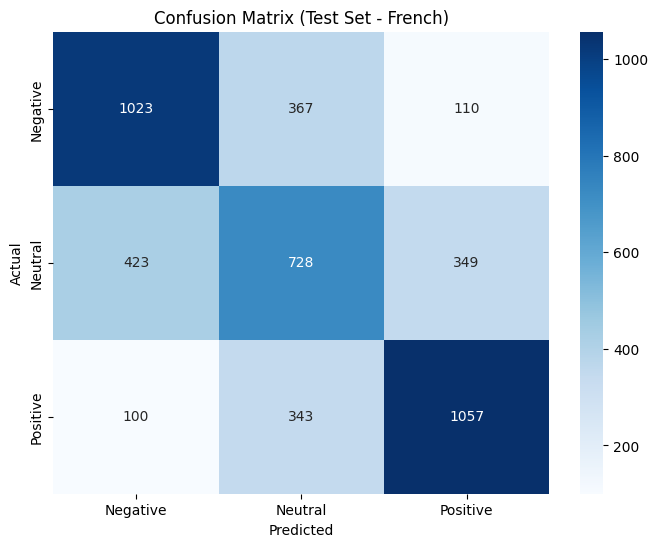

In [ ]:
# Step 1: Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Step 2: Initialize the basic CountVectorizer for French reviews
count_vectorizer_fr = CountVectorizer(strip_accents="unicode")

# Step 3: Fit and transform the French training data
X_train_fr_count = count_vectorizer_fr.fit_transform(X_train['processed_review_french'])   # BoW features for French reviews
X_val_fr_count = count_vectorizer_fr.transform(X_val['processed_review_french'])           # BoW features for validation
X_test_fr_count = count_vectorizer_fr.transform(X_test['processed_review_french'])         # BoW features for test set

# Step 4: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 5: Build and optimize the Support Vector Machine (SVM) model manually by iterating over hyperparameters
svm = SVC()

# Define the hyperparameter options manually
C_values = [0.1]  # Regularization parameter
kernels = ['linear']  # Kernel types
best_accuracy = 0
best_params = {}

# Step 6: Manually search for the best hyperparameters by looping over combinations
for C in C_values:
    for kernel in kernels:
        print(f"Training SVM with C={C}, kernel={kernel}...")

        # Train the model with the current combination of C and kernel
        svm.set_params(C=C, kernel=kernel)
        svm.fit(X_train_fr_count, y_train)

        # Evaluate on validation set
        y_val_pred = svm.predict(X_val_fr_count)

        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Update the best model if the current one performs better on the validation set
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'C': C, 'kernel': kernel}

# Step 7: Display the best hyperparameters
print(f"Best Hyperparameters: {best_params}")

# Step 8: Train the model with the best hyperparameters on the full training set
svm.set_params(**best_params)
svm.fit(X_train_fr_count, y_train)

# Step 9: Evaluate on validation set
y_val_pred = svm.predict(X_val_fr_count)
print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 10: Evaluate on test set
y_test_pred = svm.predict(X_test_fr_count)
print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 11: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - French)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Training SVM with C=1, kernel=rbf...
Best Hyperparameters: {'C': 1, 'kernel': 'rbf'}
Validation Set Performance:
Accuracy: 0.5998
Precision: 0.6023
Recall: 0.5998
F1 Score: 0.6003
Test Set Performance:
Accuracy: 0.6080
Precision: 0.6114
Recall: 0.6080
F1 Score: 0.6094


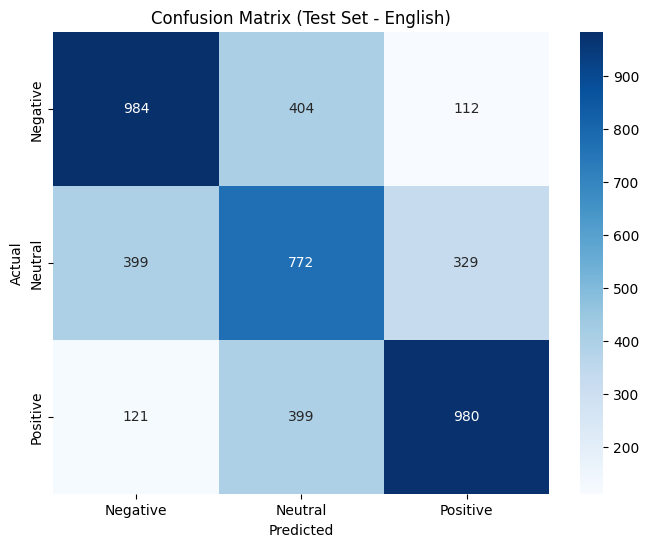

In [ ]:
# Step 1: Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Step 2: Initialize the basic CountVectorizer for English reviews
count_vectorizer_en = CountVectorizer(strip_accents="unicode")

# Step 3: Fit and transform the English training data
X_train_en_count = count_vectorizer_en.fit_transform(X_train['processed_review_english'])  # BoW features for English reviews
X_val_en_count = count_vectorizer_en.transform(X_val['processed_review_english'])          # BoW features for validation
X_test_en_count = count_vectorizer_en.transform(X_test['processed_review_english'])        # BoW features for test set

# Step 4: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 5: Build and optimize the Support Vector Machine (SVM) model manually by iterating over hyperparameters
svm = SVC()

# Define the hyperparameter options manually
C_values = [1]  # Regularization parameter
kernels = ['rbf']  # Kernel types
best_accuracy = 0
best_params = {}

# Step 6: Manually search for the best hyperparameters by looping over combinations
for C in C_values:
    for kernel in kernels:
        print(f"Training SVM with C={C}, kernel={kernel}...")

        # Train the model with the current combination of C and kernel
        svm.set_params(C=C, kernel=kernel)
        svm.fit(X_train_en_count, y_train)

        # Evaluate on validation set
        y_val_pred = svm.predict(X_val_en_count)

        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Update the best model if the current one performs better on the validation set
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'C': C, 'kernel': kernel}

# Step 7: Display the best hyperparameters
print(f"Best Hyperparameters: {best_params}")

# Step 8: Train the model with the best hyperparameters on the full training set
svm.set_params(**best_params)
svm.fit(X_train_en_count, y_train)

# Step 9: Evaluate on validation set
y_val_pred = svm.predict(X_val_en_count)
print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 10: Evaluate on test set
y_test_pred = svm.predict(X_test_en_count)
print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 11: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - English)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Training SVM with C=1, kernel=rbf...
Best Hyperparameters: {'C': 1, 'kernel': 'rbf'}
Validation Set Performance:
Accuracy: 0.6420
Precision: 0.6436
Recall: 0.6420
F1 Score: 0.6427
Test Set Performance:
Accuracy: 0.6427
Precision: 0.6451
Recall: 0.6427
F1 Score: 0.6436


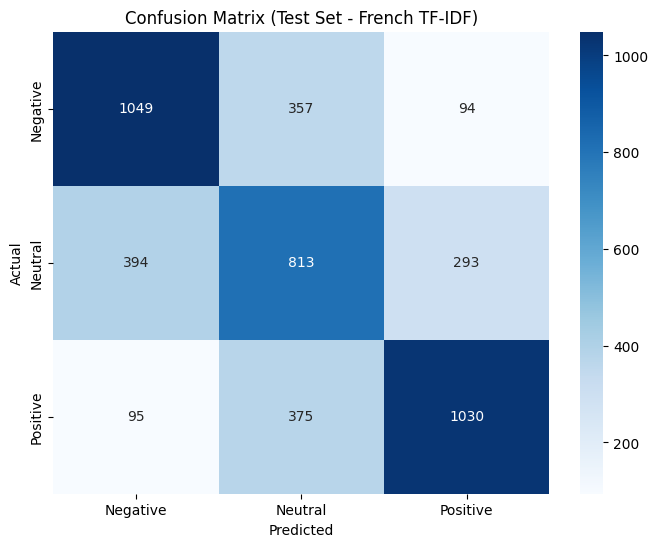

In [ ]:
# Step 1: Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 2: Initialize the basic TfidfVectorizer for French reviews
tfidf_vectorizer_fr = TfidfVectorizer(strip_accents="unicode")

# Step 3: Fit and transform the French training data
X_train_fr_tfidf = tfidf_vectorizer_fr.fit_transform(X_train['processed_review_french'])   # TF-IDF features for French reviews
X_val_fr_tfidf = tfidf_vectorizer_fr.transform(X_val['processed_review_french'])           # TF-IDF features for validation
X_test_fr_tfidf = tfidf_vectorizer_fr.transform(X_test['processed_review_french'])         # TF-IDF features for test set

# Step 4: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 5: Build and optimize the Support Vector Machine (SVM) model manually by iterating over hyperparameters
svm = SVC()

# Define the hyperparameter options manually
C_values = [1]  # Regularization parameter
kernels = ['rbf']  # Kernel types
best_accuracy = 0
best_params = {}

# Step 6: Manually search for the best hyperparameters by looping over combinations
for C in C_values:
    for kernel in kernels:
        print(f"Training SVM with C={C}, kernel={kernel}...")

        # Train the model with the current combination of C and kernel
        svm.set_params(C=C, kernel=kernel)
        svm.fit(X_train_fr_tfidf, y_train)

        # Evaluate on validation set
        y_val_pred = svm.predict(X_val_fr_tfidf)

        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Update the best model if the current one performs better on the validation set
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'C': C, 'kernel': kernel}

# Step 7: Display the best hyperparameters
print(f"Best Hyperparameters: {best_params}")

# Step 8: Train the model with the best hyperparameters on the full training set
svm.set_params(**best_params)
svm.fit(X_train_fr_tfidf, y_train)

# Step 9: Evaluate on validation set
y_val_pred = svm.predict(X_val_fr_tfidf)
print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 10: Evaluate on test set
y_test_pred = svm.predict(X_test_fr_tfidf)
print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 11: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - French TF-IDF)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Training SVM with C=1, kernel=rbf...
Best Hyperparameters: {'C': 1, 'kernel': 'rbf'}
Validation Set Performance:
Accuracy: 0.6144
Precision: 0.6175
Recall: 0.6144
F1 Score: 0.6155
Test Set Performance:
Accuracy: 0.6109
Precision: 0.6138
Recall: 0.6109
F1 Score: 0.6122


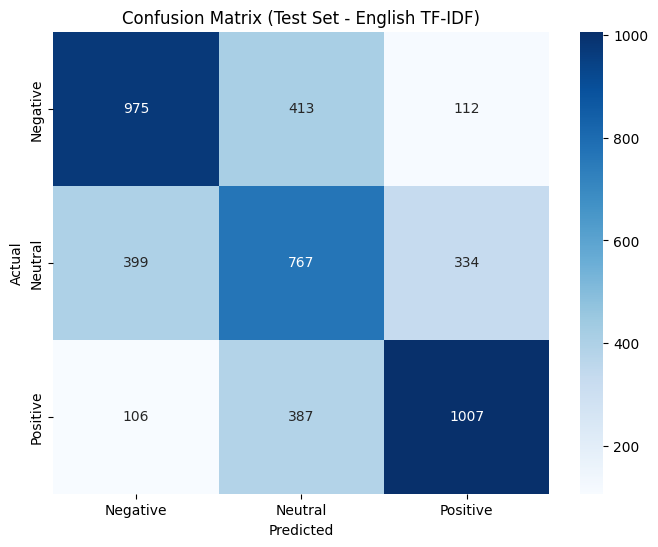

In [ ]:
# Step 1: Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 2: Initialize the basic TfidfVectorizer for English reviews
tfidf_vectorizer_en = TfidfVectorizer(strip_accents="unicode")

# Step 3: Fit and transform the English training data
X_train_en_tfidf = tfidf_vectorizer_en.fit_transform(X_train['processed_review_english'])   # TF-IDF features for English reviews
X_val_en_tfidf = tfidf_vectorizer_en.transform(X_val['processed_review_english'])           # TF-IDF features for validation
X_test_en_tfidf = tfidf_vectorizer_en.transform(X_test['processed_review_english'])         # TF-IDF features for test set

# Step 4: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 5: Build and optimize the Support Vector Machine (SVM) model manually by iterating over hyperparameters
svm = SVC()

# Define the hyperparameter options manually
C_values = [1]  # Regularization parameter
kernels = ['rbf']  # Kernel types
best_accuracy = 0
best_params = {}

# Step 6: Manually search for the best hyperparameters by looping over combinations
for C in C_values:
    for kernel in kernels:
        print(f"Training SVM with C={C}, kernel={kernel}...")

        # Train the model with the current combination of C and kernel
        svm.set_params(C=C, kernel=kernel)
        svm.fit(X_train_en_tfidf, y_train)

        # Evaluate on validation set
        y_val_pred = svm.predict(X_val_en_tfidf)

        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Update the best model if the current one performs better on the validation set
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'C': C, 'kernel': kernel}

# Step 7: Display the best hyperparameters
print(f"Best Hyperparameters: {best_params}")

# Step 8: Train the model with the best hyperparameters on the full training set
svm.set_params(**best_params)
svm.fit(X_train_en_tfidf, y_train)

# Step 9: Evaluate on validation set
y_val_pred = svm.predict(X_val_en_tfidf)
print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 10: Evaluate on test set
y_test_pred = svm.predict(X_test_en_tfidf)
print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 11: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - English TF-IDF)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
pip install gensim

Training SVM with C=10, kernel=rbf...
Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}
Validation Set Performance:
Accuracy: 0.5811
Precision: 0.5833
Recall: 0.5811
F1 Score: 0.5818
Test Set Performance:
Accuracy: 0.5809
Precision: 0.5851
Recall: 0.5809
F1 Score: 0.5823


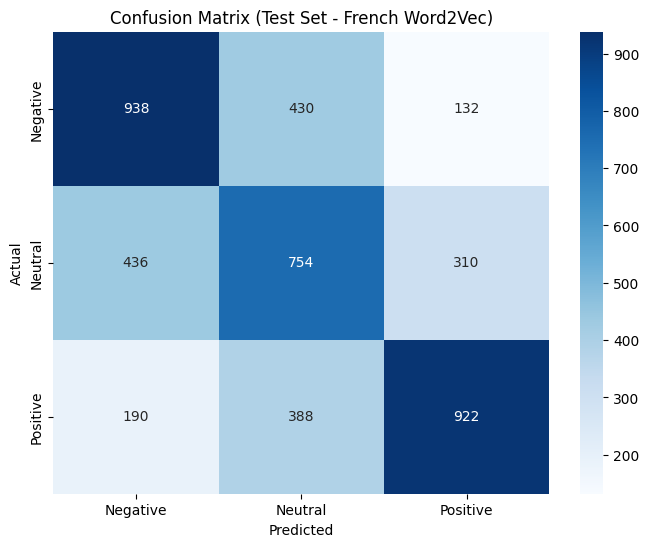

In [ ]:
# Step 1: Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

# Step 2: Train a Word2Vec model on your reviews (Assuming reviews are preprocessed in 'processed_review_french' column)
# Create a list of tokenized reviews (for example, already tokenized in 'processed_review_french' column)
tokenized_reviews_fr = [review.split() for review in X_train['processed_review_french']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_reviews_fr, vector_size=100, window=5, min_count=1, workers=4)

# Step 3: Function to get the average Word2Vec vector for each review
def get_avg_word2vec(review, model):
    word_vectors = [model.wv[word] for word in review if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Step 4: Apply Word2Vec to get review embeddings (averaging the word vectors)
X_train_fr_word2vec = np.array([get_avg_word2vec(review.split(), word2vec_model) for review in X_train['processed_review_french']])
X_val_fr_word2vec = np.array([get_avg_word2vec(review.split(), word2vec_model) for review in X_val['processed_review_french']])
X_test_fr_word2vec = np.array([get_avg_word2vec(review.split(), word2vec_model) for review in X_test['processed_review_french']])

# Step 5: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 6: Build and optimize the Support Vector Machine (SVM) model manually by iterating over hyperparameters
svm = SVC()

# Define the hyperparameter options manually
C_values = [10]  # Regularization parameter
kernels = ['rbf']  # Kernel types
best_accuracy = 0
best_params = {}

# Step 7: Manually search for the best hyperparameters by looping over combinations
for C in C_values:
    for kernel in kernels:
        print(f"Training SVM with C={C}, kernel={kernel}...")

        # Train the model with the current combination of C and kernel
        svm.set_params(C=C, kernel=kernel)
        svm.fit(X_train_fr_word2vec, y_train)

        # Evaluate on validation set
        y_val_pred = svm.predict(X_val_fr_word2vec)

        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Update the best model if the current one performs better on the validation set
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'C': C, 'kernel': kernel}

# Step 8: Display the best hyperparameters
print(f"Best Hyperparameters: {best_params}")

# Step 9: Train the model with the best hyperparameters on the full training set
svm.set_params(**best_params)
svm.fit(X_train_fr_word2vec, y_train)

# Step 10: Evaluate on validation set
y_val_pred = svm.predict(X_val_fr_word2vec)
print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 11: Evaluate on test set
y_test_pred = svm.predict(X_test_fr_word2vec)
print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 12: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - French Word2Vec)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Training SVM with C=10, kernel=rbf...
Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}
Validation Set Performance:
Accuracy: 0.5380
Precision: 0.5476
Recall: 0.5380
F1 Score: 0.5407
Test Set Performance:
Accuracy: 0.5369
Precision: 0.5462
Recall: 0.5369
F1 Score: 0.5393


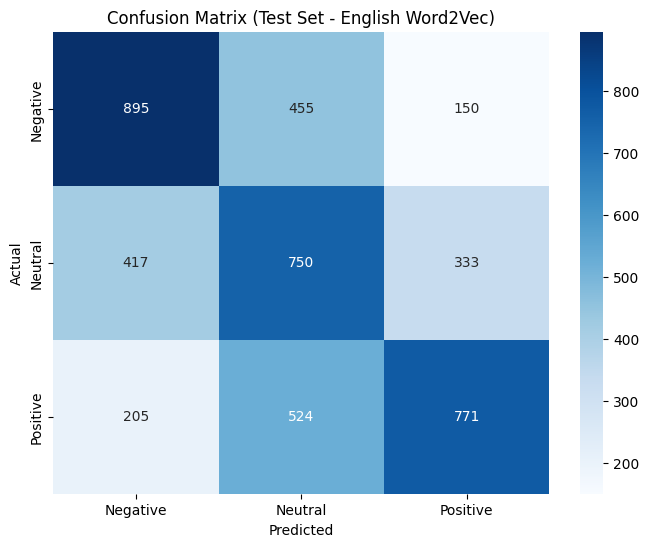

In [ ]:
# Step 1: Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

# Step 2: Prepare and tokenize English reviews
tokenized_reviews_en = [review.split() for review in X_train['processed_review_english']]

# Step 3: Train Word2Vec model on English data
word2vec_model_en = Word2Vec(sentences=tokenized_reviews_en, vector_size=100, window=5, min_count=1, workers=4)

# Step 4: Function to get the average Word2Vec vector for each review
def get_avg_word2vec(review, model):
    word_vectors = [model.wv[word] for word in review if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Step 5: Apply Word2Vec to get review embeddings
X_train_en_word2vec = np.array([get_avg_word2vec(review.split(), word2vec_model_en) for review in X_train['processed_review_english']])
X_val_en_word2vec = np.array([get_avg_word2vec(review.split(), word2vec_model_en) for review in X_val['processed_review_english']])
X_test_en_word2vec = np.array([get_avg_word2vec(review.split(), word2vec_model_en) for review in X_test['processed_review_english']])

# Step 6: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 7: Build and optimize the SVM model manually by iterating over hyperparameters
svm = SVC()
C_values = [10]
kernels = ['rbf']
best_accuracy = 0
best_params = {}

# Step 8: Manual hyperparameter tuning loop
for C in C_values:
    for kernel in kernels:
        print(f"Training SVM with C={C}, kernel={kernel}...")
        svm.set_params(C=C, kernel=kernel)
        svm.fit(X_train_en_word2vec, y_train)
        y_val_pred = svm.predict(X_val_en_word2vec)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'C': C, 'kernel': kernel}

# Step 9: Display best hyperparameters
print(f"Best Hyperparameters: {best_params}")

# Step 10: Train best model on full training set
svm.set_params(**best_params)
svm.fit(X_train_en_word2vec, y_train)

# Step 11: Evaluate on validation set
y_val_pred = svm.predict(X_val_en_word2vec)
print("Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

# Step 12: Evaluate on test set
y_test_pred = svm.predict(X_test_en_word2vec)
print("Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

# Step 13: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - English Word2Vec)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
